<a href="https://colab.research.google.com/github/aditya-shriwastava/ai-notebooks/blob/master/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam

import torchvision

device = 'cuda:0'

In [2]:
#@title DataLoader

def label(index):
    labels = ["Aeroplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
    return labels[index]
    
train_loader = DataLoader(
    torchvision.datasets.CIFAR10("./data/datasets", train=True, download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=64, shuffle=False, pin_memory=True
)

test_loader = DataLoader(
    torchvision.datasets.CIFAR10("./data/datasets", download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=64, shuffle=False, pin_memory=True
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/datasets/cifar-10-python.tar.gz to ./data/datasets
Files already downloaded and verified


In [3]:
#@title Resnet18

class Resnet18(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = torchvision.models.resnet18(num_classes=10)

  def forward(self, imgs):
    return self.model(imgs)
  
  def nll(self, imgs, labels):
    labels = torch.unsqueeze(labels, 1)
    logits = self(imgs)
    probs = F.softmax(logits, dim=1)
    nlog_probs = -torch.log(probs.gather(1, labels))
    return nlog_probs.sum()
  
  def predict_labels(self, imgs):
    with torch.no_grad():
        logits = self(imgs)
        _, labels = logits.max(1)
    return labels

In [ ]:
#@title CrappyNet

class CrappyNet(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 5, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(5, 5, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(5, 10, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, 3, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(10 * (img_size[0] // 2) * (img_size[1] // 2), 10)
        )
        
    def forward(self, imgs):
        N,C,H,W = imgs.shape
        features = self.conv(imgs)
        logits = self.fc(features.view(N, -1))
        return logits
    
    def nll(self, imgs, labels):
        labels = torch.unsqueeze(labels, 1)
        logits = self(imgs)
        probs = F.softmax(logits, dim=1)
        nlog_probs = -torch.log(probs.gather(1, labels))
        return nlog_probs.sum()
    
    def predict_labels(self, imgs):
        with torch.no_grad():
            logits = self(imgs)
            _, labels = logits.max(1)
        return labels

In [5]:
#@title Trainer

def train(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for imgs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        loss = model.nll(imgs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses
        
def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            loss = model.nll(imgs, labels)
            test_loss += loss.item() * len(labels)
    return test_loss / len(test_loader.dataset)
        
def train_epochs(model, train_loader, test_loader, train_args):
    lr = train_args["lr"]
    epochs = train_args["epochs"]
    optimizer = Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = [test(model, test_loader)]
    for epoch in range(epochs):
        print(f"epoch: {epoch+1}")
        train_losses.extend(train(model, train_loader, optimizer))
        test_losses.append(test(model, test_loader))
    return train_losses, test_losses 

In [6]:
#@title Training
_,H,W= train_loader.dataset[0][0].shape

# model = CrappyNet((H, W))
model = Resnet18()
model.to(device=device)

train_args = {'lr': 1e-3, 'epochs': 20}
train_losses, test_losses = train_epochs(model, train_loader, test_loader, train_args)

epoch: 1


100%|██████████| 782/782 [01:04<00:00, 12.10it/s]


epoch: 2


100%|██████████| 782/782 [01:04<00:00, 12.16it/s]


epoch: 3


100%|██████████| 782/782 [01:04<00:00, 12.14it/s]


epoch: 4


100%|██████████| 782/782 [01:04<00:00, 12.14it/s]


epoch: 5


100%|██████████| 782/782 [01:04<00:00, 12.14it/s]


epoch: 6


100%|██████████| 782/782 [01:04<00:00, 12.18it/s]


epoch: 7


100%|██████████| 782/782 [01:04<00:00, 12.17it/s]


epoch: 8


100%|██████████| 782/782 [01:04<00:00, 12.17it/s]


epoch: 9


100%|██████████| 782/782 [01:04<00:00, 12.17it/s]


epoch: 10


100%|██████████| 782/782 [01:04<00:00, 12.17it/s]


epoch: 11


100%|██████████| 782/782 [01:04<00:00, 12.16it/s]


epoch: 12


100%|██████████| 782/782 [01:04<00:00, 12.15it/s]


epoch: 13


100%|██████████| 782/782 [01:04<00:00, 12.13it/s]


epoch: 14


100%|██████████| 782/782 [01:04<00:00, 12.11it/s]


epoch: 15


100%|██████████| 782/782 [01:04<00:00, 12.13it/s]


epoch: 16


100%|██████████| 782/782 [01:04<00:00, 12.15it/s]


epoch: 17


100%|██████████| 782/782 [01:04<00:00, 12.15it/s]


epoch: 18


100%|██████████| 782/782 [01:04<00:00, 12.17it/s]


epoch: 19


100%|██████████| 782/782 [01:04<00:00, 12.16it/s]


epoch: 20


100%|██████████| 782/782 [01:04<00:00, 12.15it/s]


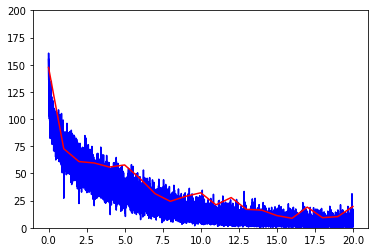

Final Train Loss: 5.088935852050781
Final Test Loss: 19.557655735321045
Percentage Correct: 0.9111599922180176


In [7]:
#@title Results

def percentace_correct(model, test_loader):
    model.eval()
    num_correct = 0
    for imgs, labels in test_loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        predicted_labels = model.predict_labels(imgs)
        num_correct += (labels == predicted_labels).sum()
    return num_correct / len(test_loader.dataset)

def plot_losses(train_losses, test_losses):
    epochs = len(test_losses) - 1
    steps_per_epoch = len(train_losses) / epochs
    train_losses_epochs = [((i+1)/steps_per_epoch) for i in range(len(train_losses))]
    test_losses_epochs = [i for i in range(len(test_losses))]
    plt.plot(train_losses_epochs, train_losses, color="blue")
    plt.plot(test_losses_epochs, test_losses, color="red")
    plt.ylim([0, 200])
    plt.show()
    
plot_losses(train_losses, test_losses)
print(f"Final Train Loss: {train_losses[-1]}")
print(f"Final Test Loss: {test_losses[-1]}")
print(f"Percentage Correct: {percentace_correct(model, test_loader)}")